<a href="https://colab.research.google.com/github/kodai-utsunomiya/memorization-and-generalization/blob/main/Disentangling_feature_and_lazy_training_in_deep_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# アーキテクチャ

# <font color="green"> `FC` クラス </font>

### ネットワークの構造

1. **入力層**: 次元数 $d$ の入力を受け取る．
2. **隠れ層**: 層数 $L$ の隠れ層があり，各隠れ層のユニット数は $h$．
3. **出力層**: 最終層は出力がスカラー値である 1 次元のベクトルを生成．

<br>

### 層ごとの計算

1. **初期化**:
   - 隠れ層 $i$ の重み行列 $W_i$ は，次のように初期化：
     
     $
     W_i \sim \mathcal{N}(0, 1)
     $

     ここで，$W_i$ のサイズは $ h \times \text{hh}_{i}$ ．
     
     $\text{hh}_{i} $ は前の層の出力ユニット数．

   - メモリ効率を考慮し，重み行列を分割：
     
     $ W_i = $

     \begin{bmatrix}
     W_i^{(0)} \\
     W_i^{(1)} \\
     \vdots \\
     W_i^{(n-1)}
     \end{bmatrix}
     
     各部分行列 $W_i^{(j)}$ はサイズ $m \times \text{hh}_{i}$．ここで，$m$ は分割サイズ．

<br>

2. **順伝播計算**:
   - 入力テンソル $x$ は，初期の隠れ層で次のように変換：
     
     $
     x^{(0)} = x W_0^T / \sqrt{d}
     $

     ここで，$W_0$ は最初の隠れ層の重み行列．バイアス項がある場合，次のように加算：
     
     $
     x^{(0)} = x^{(0)} + b_0
     $

     その後，活性化関数 $ \sigma $ を適用：
     
     $
     x^{(1)} = \sigma(x^{(0)})
     $

   - 次の隠れ層も同様に計算．一般的に，隠れ層 $i$ の計算は次のようになる：
     
     $
     x^{(i)} = x^{(i-1)} W_i^T / \sqrt{h}
     $

     ここで，$W_i$ は現在の層の重み行列．バイアス項がある場合，次のように加算：

     $
     x^{(i)} = x^{(i)} + b_i
     $

     そして，活性化関数を適用：
     
     $
     x^{(i+1)} = \sigma(x^{(i)})
     $

   - 最終層では，次のように計算：
     
     $
     x^{(L)} = x^{(L-1)} W_L^T / h + b_L
     $
     
     ここで，$W_L$ は最終層の重み行列．出力テンソル $x$ を 1 次元に変換して返す：

     $
     x^{(L)} = x^{(L)} \text{view}(-1)
     $

<br>

### 要点

- **入力層**: $d$ 次元の入力を受け取る．
- **隠れ層**: 各層で線形変換と活性化関数を適用．線形変換は以下のようにスケーリング：
  
  $
  x^{(i)} = x^{(i-1)} W_i^T / \sqrt{h}
  $
- **出力層**: 最終層で線形変換を行い，スカラー値に変換：
  
  $
  x^{(L)} = x^{(L-1)} W_L^T / h + b_L
  $

# <font color="green">`Wide_ResNet` クラス </font>

### 1. ネットワークの構造

- 初期の畳み込み層
- 複数の Wide-ResNet ブロックからなるレイヤー
- 最終的な線形層

<br>

### 2. 初期の畳み込み層

最初に入力データ $ x $ に対して，畳み込み演算を行う：

$ \mathbf{z}_1 = \text{conv}(x) $

ここで，`conv` はカーネルサイズ $ 3 \times 3 $，ストライド $ 1 $，パディング $ 1 $ の畳み込み演算．出力のチャネル数は $ nStages[0] $．

<br>

### 3. Wide-ResNet レイヤー

`Wide_ResNet` は，複数の `wide_basic` ブロックからなるレイヤーを持つ．各レイヤーは以下のように定義：

- **ブロック数**: $ n $
- **ストライド**: 最初のブロックのストライドは `stride` で指定し，以降はすべてストライド $ 1 $

各レイヤー $ l $ は以下のように定義：

$ \mathbf{z}_l = \text{layer}_l(\mathbf{z}_{l-1}) $

ここで，`layer` は `self._wide_layer` メソッドによって定義し，複数の `wide_basic` ブロックがストライドに従って連結．

<br>

### 4. Wide-ResNet ブロック

`wide_basic` ブロック内での処理は次のように表される：

$ \mathbf{y} = \text{conv2}(\text{act}(\text{conv1}(\mathbf{x}))) $

ここで，$\text{conv1}$ と $\text{conv2}$ はそれぞれカーネルサイズ $ 3 \times 3 $ の畳み込み層であり，$\text{act}$ は活性化関数．

ショートカット接続の処理は次のように行う：

$ \text{shortcut} = \text{conv}_{shortcut}(\mathbf{x}) $

（ストライドやチャネル数が異なる場合のみ，1x1 畳み込みを適用．）

最終的な出力は，以下のように角度 $ \theta $ に基づく線形結合で計算：

$ \mathbf{z}_\text{out} = \cos(\theta) \cdot \text{shortcut} + \sin(\theta) \cdot \mathbf{y} $

ここで，角度 $\theta$ は `mix_angle` に基づいて計算され，ラジアンに変換：

$ \theta = \frac{\text{mix_angle} \times \pi}{180} $

<br>

### 5. 最終線形層

最終的な特徴マップ $\mathbf{z}_\text{final}$ は，全てのレイヤーを通過した後にフラット化し，平均化：

$ \mathbf{z}_\text{flat} = \text{flatten}(\mathbf{z}_\text{final}) $

$ \mathbf{z}_\text{avg} = \text{mean}(\mathbf{z}_\text{flat}, \text{dim}=2) $

最後に線形変換を適用し，クラス数 $ \text{num_classes} $ に基づく出力を得る：

$ \mathbf{z}_\text{output} = \mathbf{z}_\text{avg} \cdot \frac{\mathbf{W}}{h} + \mathbf{b} $

ここで，$\mathbf{W}$ は最終線形層の重み，$h$ は重みのサイズ，$\mathbf{b}$ はバイアス．

<br>

### 6. 出力のフラット化

もし最終的な出力の次元が $1$ の場合，出力をフラット化：

$ \mathbf{z}_\text{output} = \text{flatten}(\mathbf{z}_\text{output}, \text{dim}=0) $

<br>

### まとめ

Wide-ResNet の全体的な流れ：

1. **初期の畳み込み層**:
   $ \mathbf{z}_1 = \text{conv}(x) $

2. **Wide-ResNet レイヤー**:

   $ \mathbf{z}_l = \text{layer}_l(\mathbf{z}_{l-1}) \text{ for } l = 1, 2, 3 $

3. **Wide-ResNet ブロック**:

   $ \mathbf{z}_\text{out} = \cos(\theta) \cdot \text{shortcut} + \sin(\theta) \cdot \mathbf{y} $

4. **最終線形層**:

   $ \mathbf{z}_\text{avg} = \text{mean}(\text{flatten}(\mathbf{z}_\text{final}), \text{dim}=2) $

   $ \mathbf{z}_\text{output} = \mathbf{z}_\text{avg} \cdot \frac{\mathbf{W}}{h} + \mathbf{b} $

5. **出力のフラット化**（必要に応じて）:

   $ \mathbf{z}_\text{output} = \text{flatten}(\mathbf{z}_\text{output}, \text{dim}=0) $

In [2]:
# pylint: disable=E1101, C, arguments-differ
"""
Defines three architectures:
- Fully connecetd `FC`
- Convolutional `CV`
- And a resnet `Wide_ResNet`
"""
import functools
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

"""
全結合ネットワーク（Fully Connected Network, FC）のクラスを定義．
このネットワークは，任意の層数 L を持ち，各層のユニット数は h で指定される．
活性化関数 act は任意に指定可能で，バイアス項の有無も指定可能．
"""

class FC(nn.Module):
    def __init__(self, d, h, L, act, bias=False):
        super().__init__()

        # ネットワークの初期化
        hh = d  # 入力の次元数
        for i in range(L):
            # 隠れ層の重み行列を正規分布で初期化
            W = torch.randn(h, hh)

            # メモリ効率を考慮し，重み行列を部分行列に分割して ParameterList に格納
            # next two line are here to avoid memory issue when computing the kerne
            n = max(1, 128 * 256 // hh)  # 分割サイズを計算
            W = nn.ParameterList([nn.Parameter(W[j: j+n]) for j in range(0, len(W), n)])

            # 分割した重み行列をレイヤーとして登録
            setattr(self, "W{}".format(i), W)

            # バイアス項が指定されている場合は，それをゼロで初期化して登録
            if bias:
                self.register_parameter("B{}".format(i), nn.Parameter(torch.zeros(h)))

            # 次のレイヤーの入力次元は現在の隠れ層のユニット数になる
            hh = h

        # 最終層の重み行列を初期化（出力がスカラー値なので次元は (1, h)）
        self.register_parameter("W{}".format(L), nn.Parameter(torch.randn(1, hh)))

        # バイアス項が指定されている場合は，最終層のバイアスをゼロで初期化
        if bias:
            self.register_parameter("B{}".format(L), nn.Parameter(torch.zeros(1)))

        # クラス変数としてレイヤー数，活性化関数，バイアスの有無を保持
        self.L = L
        self.act = act
        self.bias = bias

    def forward(self, x):
        # 順伝播計算
        for i in range(self.L + 1):
            # i 番目の層の重み行列を取得
            W = getattr(self, "W{}".format(i))

            # ParameterList 形式の重み行列をフルの行列に結合
            if isinstance(W, nn.ParameterList):
                W = torch.cat(list(W))

            # バイアス項が指定されている場合は，バイアスを取得
            if self.bias:
                B = self.bias * getattr(self, "B{}".format(i))
            else:
                B = 0

            # 現在の入力の次元数を取得
            h = x.size(1)

            if i < self.L:
                # 隠れ層での線形変換とスケーリング，そして活性化関数の適用
                x = x @ (W.t() / h ** 0.5)  # 重み行列との積（次元スケーリング）
                x = self.act(x + B)  # バイアス項を加えた後，活性化関数を適用
            else:
                # 最終層での線形変換（出力はスカラー値）
                x = x @ (W.t() / h) + B  # スカラー出力

        # 出力を 1 次元のテンソルに変換して返す
        return x.view(-1)


class CV(nn.Module):
    def __init__(self, d, h, L1, L2, act, h_base, fsz, pad, stride_first):
        super().__init__()

        # 初期入力チャネル数
        h1 = d

        # L1: 深さのレベル（層数）
        for i in range(L1):
            # 各レベルでの出力チャネル数
            h2 = round(h * h_base ** i)
            for j in range(L2):
                # 各レイヤーでの畳み込みフィルタを定義
                # h2: 現在のレイヤーの出力チャネル数
                # fsz: カーネルサイズ
                W = nn.ParameterList([nn.Parameter(torch.randn(h1, fsz, fsz)) for _ in range(h2)])
                setattr(self, "W{}_{}".format(i, j), W)  # 各レイヤーのパラメータを設定
                h1 = h2 # 入力チャネル数を更新

        # 最終の線形変換層のパラメータ
        self.W = nn.Parameter(torch.randn(h1))

        # パラメータの保存
        self.L1 = L1   # 深さのレベル数
        self.L2 = L2   # 各レベルのレイヤー数
        self.act = act    # 活性化関数
        self.pad = pad    # パディング
        self.stride_first = stride_first  # 最初のレイヤーのストライド設定

    def forward(self, x):
        """
        順伝播計算を実行
        """

        # 各レベルを順に処理
        for i in range(self.L1):
            for j in range(self.L2):
                # 入力サイズが5x5以上であることを確認
                assert x.size(2) >= 5 and x.size(3) >= 5

                # 現在のレイヤーのパラメータを取得
                W = getattr(self, "W{}_{}".format(i, j))
                W = torch.stack(list(W))  # リストをテンソルに変換

                # ストライド設定: 初回レイヤーや最初のレベルではストライド2，それ以外は1
                stride = 2 if j == 0 and (i > 0 or self.stride_first) else 1

                # カーネルの平均値で正規化
                h = W[0].numel()
                x = nn.functional.conv2d(x, W / h ** 0.5, None, stride=stride, padding=self.pad)
                x = self.act(x)  # 活性化関数を適用

        # 特徴マップのフラット化と平均化
        x = x.flatten(2).mean(2)

        # 最終線形変換: 特徴マップを最終出力に変換
        W = self.W
        h = len(W)
        x = x @ (W / h)   # 行列の内積計算と正規化
        return x.view(-1)   # 出力をフラット化


class conv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, bias=True):
        super().__init__()

        # 初期の畳み込みカーネルを定義
        w = torch.randn(out_planes, in_planes, kernel_size, kernel_size)
        n = max(1, 256**2 // w[0].numel())
        # パラメータを分割して保持
        self.w = nn.ParameterList([nn.Parameter(w[j: j + n]) for j in range(0, len(w), n)])

        # バイアスが必要な場合の設定
        self.b = nn.Parameter(torch.zeros(out_planes)) if bias else None

        # ストライドとパディングの設定
        self.stride = stride
        self.padding = padding

    def forward(self, x):
        """
        順伝播計算を実行
        """

        # 全てのカーネルパラメータを結合
        w = torch.cat(list(self.w))
        # カーネルの平均値で正規化
        h = w[0].numel()
        # 畳み込み演算を実行
        return F.conv2d(x, w / h ** 0.5, self.b, self.stride, self.padding)

class wide_basic(nn.Module):
    """
    Wide-ResNet の基本的なブロックを定義するクラス．
    このクラスは，2 つの畳み込み層とショートカットパスを持ち，活性化関数と角度に基づく線形結合を行う．
    """
    def __init__(self, in_planes, planes, act, stride=1, mix_angle=45):
        """
        コンストラクタでブロックの初期設定を行う．

        Parameters:
        - in_planes: 入力チャネル数
        - planes: 出力チャネル数
        - act: 活性化関数
        - stride: 畳み込みのストライド（デフォルトは1）
        - mix_angle: ミックス角度（デフォルトは45度）
        """
        super().__init__()
        # 第一の畳み込み層
        self.conv1 = conv(in_planes, planes, kernel_size=3, padding=1, bias=True)
        # 第二の畳み込み層
        self.conv2 = conv(planes, planes, kernel_size=3, stride=stride, padding=1, bias=True)

        # ショートカットパスの初期化
        self.shortcut = nn.Sequential()
        # ストライドが 1 でないか，入力と出力のチャネル数が異なる場合に 1x1 の畳み込みを使ってショートカットパスを調整
        if stride != 1 or in_planes != planes:
            self.shortcut = conv(in_planes, planes, kernel_size=1, stride=stride, bias=True)

        # 活性化関数
        self.act = act
        # ミックス角度（度数法からラジアンに変換）
        self.mix_angle = mix_angle

    def forward(self, x):
        """
        順伝播計算を行う．

        Parameters:
        - x: 入力テンソル

        Returns:
        - out: 出力テンソル
        """
        # 入力 x に対して活性化関数を適用し，第一の畳み込み層を通過
        out = self.conv1(self.act(x))
        # 活性化関数を適用し，第二の畳み込み層を通過
        out = self.conv2(self.act(out))
        # ショートカットパスの出力を取得
        cut = self.shortcut(x)

        # ミックス角度をラジアンに変換
        a = self.mix_angle * math.pi / 180
        # ミックス角度に基づく線形結合
        out = math.cos(a) * cut + math.sin(a) * out

        return out

class Wide_ResNet(nn.Module):
    """
    Wide Residual Network（Wide-ResNet）のクラスを定義．
    深さ depth は 6n+4 の形で指定し，各層のユニット数を h で指定．
    mix_angle は Wide-ResNet のブロック内での角度に関連するハイパーパラメータ．
    """

    def __init__(self, d, depth, h, act, num_classes, mix_angle=45):
        super().__init__()

        # 深さが6の倍数に4を加えた形であることを確認
        assert (depth % 6 == 4), 'Wide-resnet depth should be 6n+4'
        n = (depth - 4) // 6

        # 各ステージの出力チャネル数を定義
        nStages = [16, 16 * h, 32 * h, 64 * h]
        # Wide-ResNet の基本ブロックを指定するためのファクトリ関数
        block = functools.partial(wide_basic, act=act, mix_angle=mix_angle)

        # 初期の畳み込み層の定義
        self.conv1 = conv(d, nStages[0], kernel_size=3, stride=1, padding=1, bias=True)
        self.in_planes = nStages[0]

        # 各レイヤーの定義（複数のブロックから成る）
        self.layer1 = self._wide_layer(block, nStages[1], n, stride=1)
        self.layer2 = self._wide_layer(block, nStages[2], n, stride=2)
        self.layer3 = self._wide_layer(block, nStages[3], n, stride=2)

        # 最終線形層の定義（出力次元はクラス数）
        self.linear = nn.Parameter(torch.randn(num_classes, nStages[3]))
        self.bias = nn.Parameter(torch.zeros(num_classes))
        self.act = act

    def _wide_layer(self, block, planes, num_blocks, stride):
        """
        Wide-ResNet の層を定義．
        各層は指定された数のブロックで構成され，最初のブロックのみ stride でダウンサンプリングを行う
        """
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []

        # 各ブロックを追加
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride=stride))
            self.in_planes = planes

        return nn.Sequential(*layers)

    def forward(self, x):
        """
        順伝播計算を実行
        """

        # 初期の畳み込み層を通過
        out = self.conv1(x)

        # 各層を順に通過
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)

        # 活性化関数の適用
        out = self.act(out)

        # 特徴マップをフラット化し，各特徴の平均を取る
        out = out.flatten(2).mean(2)

        # 線形変換を行う（クラス数に対する出力）
        h = self.linear.size(1)
        out = F.linear(out, self.linear / h, self.bias)

        # 出力次元が1の場合はフラット化
        if out.size(1) == 1:
            out = out.flatten(0)

        return out

# データセット

In [5]:
# pylint: disable=no-member, E1102, C
"""
- Load mnist or cifar10
- perform PCA
- shuffle the dataset
- split in train and test set in an equilibrated way (same amount of each classes)
"""
import functools

import torch


def pca(x, d, whitening):
    '''
    主成分分析（PCA）を実行する関数．

    :param x: 入力データテンソル．形状は [P, ...] で，P は特徴量の次元．
    :param d: 主成分の数．出力の次元．
    :param whitening: データをホワイトニングするかどうかのフラグ．
    :return: PCAにより次元削減されたデータ．形状は [P, d]．
    '''

    # データをフラット化し，中心化
    # 入力テンソル x を 2 次元行列に変換．ここで，最初の次元が特徴量の次元 P になる．
    z = x.flatten(1)

    # 各サンプルの平均を計算し，その平均を引いてデータを中心化
    mu = z.mean(0)
    z = z - mu  # 中心化されたデータ
    cov = (z.t() @ z) / len(z) # 共分散行列

    # 共分散行列の固有値と固有ベクトルを計算
    val, vec = cov.symeig(eigenvectors=True) # 固有値と固有ベクトルを計算
    val, idx = val.sort(descending=True) # 固有値を降順にソートし，インデックスを取得
    vec = vec[:, idx]  # ソートされた固有ベクトルを取得

    # 主成分を計算
    # データを主成分に射影．vec[:, :d] は最初の d 個の主成分（固有ベクトル）．
    u = z @ vec[:, :d]  # 主成分に変換されたデータ

    # ホワイトニング処理を実行
    # whitening フラグが True の場合，データをホワイトニング（固有値の平方根の逆数でスケーリング）
    if whitening:
        u.mul_(val[:d].rsqrt())  # ホワイトニング（スケーリング）
    else:
        u.mul_(val[:d].mean().rsqrt())  # ホワイトニングしない場合のスケーリング

    return u  # PCA により次元削減されたデータを返す


def get_binary_pca_dataset(dataset, p, d, whitening, seed=None, device=None):
    '''
    バイナリ分類用にPCAを適用したデータセットを取得する関数

    :param dataset: 使用するデータセットの名前（例: "mnist", "cifar10"など）
    :param p: トレーニングデータとテストデータを分割するためのサンプル数の基準
    :param d: PCAによる次元削減後の次元数
    :param whitening: PCAの後にデータをホワイトニングするかどうかのフラグ
    :param seed: データのシャッフルに使用するランダムシード
    :param device: データを移動するデバイス（CPUまたはGPU）
    :return: トレーニングセットとテストセットのタプル．各セットは (特徴量, ラベル) のタプル
    '''

    # ランダムシードが指定されていない場合は，ランダムに生成
    if seed is None:
        seed = torch.randint(2 ** 32, (), dtype=torch.long).item()

    # 正規化されたデータセットを取得
    x, y = get_normalized_dataset(dataset, seed)

    # PCAを適用して次元を削減し，指定されたデバイスにデータを移動
    x = pca(x, d, whitening).to(device)

    # ラベルをバイナリに変換．ここでは，偶数クラスは 1，奇数クラスは -1 に変換
    y = (2 * (torch.arange(len(y)) % 2) - 1).type(x.dtype).to(device)

    # トレーニングデータとテストデータに分割
    xtr = x[:p]
    xte = x[p:]
    ytr = y[:p]
    yte = y[p:]

    return (xtr, ytr), (xte, yte)


def get_dataset(dataset, p, seed=None, device=None):
    '''
    指定されたデータセットを取得し，トレーニングセットとテストセットに分割する関数

    :param dataset: 使用するデータセットの名前（例: "mnist", "cifar10"など）
    :param p: トレーニングデータとテストデータを分割するためのサンプル数の基準
    :param seed: データのシャッフルに使用するランダムシード
    :param device: データを移動するデバイス（CPUまたはGPU）
    :return: トレーニングセットとテストセットのタプル．各セットは (特徴量, ラベル) のタプル
    '''
    if seed is None:
        seed = torch.randint(2 ** 32, (), dtype=torch.long).item()

    # 正規化されたデータセットを取得
    x, y = get_normalized_dataset(dataset, seed)

    # データを指定されたデバイスに移動
    x = x.to(device)
    y = y.to(device)

    # トレーニングデータとテストデータに分割
    xtr = x[:p]
    xte = x[p:]
    ytr = y[:p]
    yte = y[p:]

    return (xtr, ytr), (xte, yte)


def get_binary_dataset(dataset, p, seed=None, device=None):
    '''
    バイナリ分類用にデータセットを取得する関数
    '''
    if seed is None:
        seed = torch.randint(2 ** 32, (), dtype=torch.long).item()

    # 正規化されたデータセットを取得
    x, y = get_normalized_dataset(dataset, seed)

    # データを指定されたデバイスに移動
    x = x.to(device)
    # ラベルをバイナリに変換．ここでは，偶数クラスは 1，奇数クラスは -1 に変換
    y = (2 * (torch.arange(len(y)) % 2) - 1).type(x.dtype).to(device)

    # トレーニングデータとテストデータに分割
    xtr = x[:p]
    xte = x[p:]
    ytr = y[:p]
    yte = y[p:]

    return (xtr, ytr), (xte, yte)


@functools.lru_cache(maxsize=2)
def get_normalized_dataset(dataset, seed):
    '''
    指定されたデータセットを正規化し，シャッフルして取得する関数

    :param dataset: 使用するデータセットの名前（例: "mnist", "cifar10" など）
    :param seed: データのシャッフルに使用するランダムシード
    :return: 正規化されたデータとラベルのタプル．データは特徴量とラベルのテンソルとして返される．
    '''
    import torchvision
    from itertools import chain

    # データをTensor型に変換するための変換処理を定義
    transform = torchvision.transforms.ToTensor()

    # 指定されたデータセットに応じてデータをダウンロードし，変換を適用
    if dataset == "mnist":
        # MNISTデータセットをダウンロードし，トレーニングとテストのデータを取得
        tr = torchvision.datasets.MNIST('~/.torchvision/datasets/MNIST', train=True, download=True, transform=transform)
        te = torchvision.datasets.MNIST('~/.torchvision/datasets/MNIST', train=False, transform=transform)
    elif dataset == "kmnist":
        tr = torchvision.datasets.KMNIST('~/.torchvision/datasets/KMNIST', train=True, download=True, transform=transform)
        te = torchvision.datasets.KMNIST('~/.torchvision/datasets/KMNIST', train=False, transform=transform)
    elif dataset == "emnist-letters":
        tr = torchvision.datasets.EMNIST('~/.torchvision/datasets/EMNIST', train=True, download=True, transform=transform, split='letters')
        te = torchvision.datasets.EMNIST('~/.torchvision/datasets/EMNIST', train=False, transform=transform, split='letters')
    elif dataset == "fashion":
        tr = torchvision.datasets.FashionMNIST('~/.torchvision/datasets/FashionMNIST', train=True, download=True, transform=transform)
        te = torchvision.datasets.FashionMNIST('~/.torchvision/datasets/FashionMNIST', train=False, transform=transform)
    elif dataset == "cifar10":
        tr = torchvision.datasets.CIFAR10('~/.torchvision/datasets/CIFAR10', train=True, download=True, transform=transform)
        te = torchvision.datasets.CIFAR10('~/.torchvision/datasets/CIFAR10', train=False, transform=transform)
    elif dataset == "cifar_catdog":
        # CIFAR-10データセットから猫と犬のクラスを抽出
        tr = [(x, y) for x, y in torchvision.datasets.CIFAR10('~/.torchvision/datasets/CIFAR10', train=True, download=True, transform=transform) if y in [3, 5]]
        te = [(x, y) for x, y in torchvision.datasets.CIFAR10('~/.torchvision/datasets/CIFAR10', train=False, transform=transform) if y in [3, 5]]
    elif dataset == "cifar_shipbird":
        # CIFAR-10データセットから船と鳥のクラスを抽出
        tr = [(x, y) for x, y in torchvision.datasets.CIFAR10('~/.torchvision/datasets/CIFAR10', train=True, download=True, transform=transform) if y in [8, 2]]
        te = [(x, y) for x, y in torchvision.datasets.CIFAR10('~/.torchvision/datasets/CIFAR10', train=False, transform=transform) if y in [8, 2]]
    elif dataset == "cifar_catplane":
        # CIFAR-10データセットから猫と飛行機のクラスを抽出
        tr = [(x, y) for x, y in torchvision.datasets.CIFAR10('~/.torchvision/datasets/CIFAR10', train=True, download=True, transform=transform) if y in [3, 0]]
        te = [(x, y) for x, y in torchvision.datasets.CIFAR10('~/.torchvision/datasets/CIFAR10', train=False, transform=transform) if y in [3, 0]]
    else:
        raise ValueError("unknown dataset")

    # トレーニングデータとテストデータを結合し，データをテンソル形式でリストに変換
    dataset = list(tr) + list(te)
    # データとラベルをテンソル形式に変換し，ラベルを整数型に変換
    dataset = [(x.type(torch.float64), int(y)) for x, y in dataset]
    # ラベルのクラスを抽出し，ソート
    classes = sorted({y for x, y in dataset})

    # クラスごとにデータを分けてリストに格納
    sets = [[(x, y) for x, y in dataset if y == i] for i in classes]

    # ランダムシードを設定し，データをシャッフル
    torch.manual_seed(seed)
    sets = [
        [x[i] for i in torch.randperm(len(x))]
        for x in sets
    ]

    # シャッフルされたデータを元に戻し，リストを再結合
    dataset = list(chain(*zip(*sets)))

    # データをテンソルにスタックし，正規化
    x = torch.stack([x for x, y in dataset])
    x = x - x.mean(0)   # データを中心化
    # データの標準化（各サンプルを標準化）
    x = (x[0].numel() ** 0.5) * x / x.flatten(1).norm(dim=1).view(-1, *(1,) * (x.dim() - 1))

    # ラベルをテンソルに変換
    y = torch.tensor([y for x, y in dataset], dtype=torch.long)

    return x, y  # 正規化されたデータとラベルのテンソルを返す

# ダイナミクス

In [ ]:
# pylint: disable=E1101, C
"""
This file implements a continuous version of momentum SGD
Dynamics that compares the angle of the gradient between steps and keep it small

- stop when margins are reached

It contains two implementation of the same dynamics:
1. `train_regular` for any kind of models
2. `train_kernel` only for linear models
"""
import copy
import itertools
import math
from time import perf_counter

import torch

# from hessian import gradient

#####################################################################################################
def gradient(outputs, inputs, grad_outputs=None, retain_graph=None, create_graph=False):
    r'''
    Compute the gradient of `outputs` with respect to `inputs`
    ```
    gradient(x.sum(), x)
    gradient((x * y).sum(), [x, y])
    ```
    '''
    if torch.is_tensor(inputs):
        inputs = [inputs]
    else:
        inputs = list(inputs)
    grads = torch.autograd.grad(outputs, inputs, grad_outputs,
                                allow_unused=True,
                                retain_graph=retain_graph,
                                create_graph=create_graph)
    grads = [x if x is not None else torch.zeros_like(y) for x, y in zip(grads, inputs)]
    return torch.cat([x.contiguous().view(-1) for x in grads])
#####################################################################################################


def loglinspace(rate, step, end=None):
    t = 0
    while end is None or t <= end:
        yield t
        t = int(t + 1 + step * (1 - math.exp(-t * rate / step)))


class ContinuousMomentum(torch.optim.Optimizer):
    r"""Implements a continuous version of momentum.

    d/dt velocity = -1/tau (velocity + grad)
     or
    d/dt velocity = -mu/t (velocity + grad)

    d/dt parameters = velocity
    """

    def __init__(self, params, dt, tau):
        defaults = dict(dt=dt, tau=tau)
        super().__init__(params, defaults)

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable): A closure that reevaluates the model and
                returns the loss. Optional for most optimizers.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            tau = group['tau']
            dt = group['dt']

            for p in group['params']:
                if p.grad is None:
                    continue

                param_state = self.state[p]
                if 't' not in param_state:
                    t = param_state['t'] = 0
                else:
                    t = param_state['t']

                if tau != 0:
                    if 'velocity' not in param_state:
                        v = param_state['velocity'] = torch.zeros_like(p.data)
                    else:
                        v = param_state['velocity']

                if tau > 0:
                    x = math.exp(-dt / tau)
                    v.mul_(x).add_(-(1 - x), p.grad.data)
                elif tau < 0:
                    mu = -tau
                    x = (t / (t + dt)) ** mu
                    v.mul_(x).add_(-(1 - x), p.grad.data)
                else:
                    v = -p.grad.data

                p.data.add_(dt, v)
                param_state['t'] += dt

        return loss


def make_step(f, optimizer, dt, grad):
    i = 0
    for p in f.parameters():
        n = p.numel()
        p.grad = grad[i: i + n].view_as(p)
        i += n

    for param_group in optimizer.param_groups:
        param_group['dt'] = dt

    optimizer.step()

    for p in f.parameters():
        p.grad = None


def train_regular(f0, x, y, tau, max_walltime, alpha, loss, subf0, max_dgrad=math.inf, max_dout=math.inf):
    f = copy.deepcopy(f0)

    with torch.no_grad():
        out0 = f0(x) if subf0 else 0

    dt = 1
    step_change_dt = 0
    optimizer = ContinuousMomentum(f.parameters(), dt=dt, tau=tau)

    checkpoint_generator = loglinspace(0.01, 100)
    checkpoint = next(checkpoint_generator)
    wall = perf_counter()
    t = 0
    converged = False

    out = f(x)
    grad = gradient(loss((out - out0) * y).mean(), f.parameters())

    for step in itertools.count():

        state = copy.deepcopy((f.state_dict(), optimizer.state_dict(), t))

        while True:
            make_step(f, optimizer, dt, grad)
            t += dt
            current_dt = dt

            new_out = f(x)
            new_grad = gradient(loss((new_out - out0) * y).mean(), f.parameters())

            dout = (out - new_out).mul(alpha).abs().max().item()
            if grad.norm() == 0 or new_grad.norm() == 0:
                dgrad = 0
            else:
                dgrad = (grad - new_grad).norm().pow(2).div(grad.norm() * new_grad.norm()).item()

            if dgrad < max_dgrad and dout < max_dout:
                if dgrad < 0.5 * max_dgrad and dout < 0.5 * max_dout:
                    dt *= 1.1
                break

            dt /= 10

            print("[{} +{}] [dt={:.1e} dgrad={:.1e} dout={:.1e}]".format(step, step - step_change_dt, dt, dgrad, dout), flush=True)
            step_change_dt = step
            f.load_state_dict(state[0])
            optimizer.load_state_dict(state[1])
            t = state[2]

        out = new_out
        grad = new_grad

        save = False

        if step == checkpoint:
            checkpoint = next(checkpoint_generator)
            assert checkpoint > step
            save = True

        if (alpha * (out - out0) * y >= 1).all() and not converged:
            converged = True
            save = True

        if save:
            state = {
                'step': step,
                'wall': perf_counter() - wall,
                't': t,
                'dt': current_dt,
                'dgrad': dgrad,
                'dout': dout,
                'norm': sum(p.norm().pow(2) for p in f.parameters()).sqrt().item(),
                'dnorm': sum((p0 - p).norm().pow(2) for p0, p in zip(f0.parameters(), f.parameters())).sqrt().item(),
                'grad_norm': grad.norm().item(),
            }

            yield f, state, converged

        if converged:
            break

        if perf_counter() > wall + max_walltime:
            break

        if torch.isnan(out).any():
            break



def train_kernel(ktrtr, ytr, tau, max_walltime, alpha, loss_prim, max_dgrad=math.inf, max_dout=math.inf):
    otr = ktrtr.new_zeros(len(ytr))
    velo = otr.clone()

    dt = 1
    step_change_dt = 0

    checkpoint_generator = loglinspace(0.01, 100)
    checkpoint = next(checkpoint_generator)
    wall = perf_counter()
    t = 0
    converged = False

    lprim = loss_prim(otr * ytr) * ytr
    grad = ktrtr @ lprim / len(ytr)

    for step in itertools.count():

        state = copy.deepcopy((otr, velo, t))

        while True:

            if tau > 0:
                x = math.exp(-dt / tau)
                velo.mul_(x).add_(-(1 - x), grad)
            elif tau < 0:
                mu = -tau
                x = (t / (t + dt)) ** mu
                velo.mul_(x).add_(-(1 - x), grad)
            else:
                velo.copy_(-grad)
            otr.add_(dt, velo)

            t += dt
            current_dt = dt

            lprim = loss_prim(otr * ytr) * ytr
            new_grad = ktrtr @ lprim / len(ytr)

            dout = velo.mul(dt * alpha).abs().max().item()
            if grad.norm() == 0 or new_grad.norm() == 0:
                dgrad = 0
            else:
                dgrad = (grad - new_grad).norm().pow(2).div(grad.norm() * new_grad.norm()).item()

            if dgrad < max_dgrad and dout < max_dout:
                if dgrad < 0.1 * max_dgrad and dout < 0.1 * max_dout:
                    dt *= 1.1
                break

            dt /= 10

            print("[{} +{}] [dt={:.1e} dgrad={:.1e} dout={:.1e}]".format(step, step - step_change_dt, dt, dgrad, dout), flush=True)
            step_change_dt = step
            otr.copy_(state[0])
            velo.copy_(state[1])
            t = state[2]

        grad = new_grad

        save = False

        if step == checkpoint:
            checkpoint = next(checkpoint_generator)
            assert checkpoint > step
            save = True

        if (alpha * otr * ytr >= 1).all() and not converged:
            converged = True
            save = True

        if save:
            state = {
                'step': step,
                'wall': perf_counter() - wall,
                't': t,
                'dt': current_dt,
                'dgrad': dgrad,
                'dout': dout,
                'grad_norm': grad.norm().item(),
            }

            yield otr, velo, grad, state, converged

        if converged:
            break

        if perf_counter() > wall + max_walltime:
            break

        if torch.isnan(otr).any():
            break

# カーネル

In [ ]:
# pylint: disable=no-member, C, not-callable
"""
Computes the Gram matrix of a given model
"""

def compute_kernels(f, xtr, xte):
    # from hessian import gradient

    ktrtr = xtr.new_zeros(len(xtr), len(xtr))
    ktetr = xtr.new_zeros(len(xte), len(xtr))
    ktete = xtr.new_zeros(len(xte), len(xte))

    params = []
    current = []
    for p in sorted(f.parameters(), key=lambda p: p.numel(), reverse=True):
        current.append(p)
        if sum(p.numel() for p in current) > 2e9 // (8 * (len(xtr) + len(xte))):
            if len(current) > 1:
                params.append(current[:-1])
                current = current[-1:]
            else:
                params.append(current)
                current = []
    if len(current) > 0:
        params.append(current)

    for i, p in enumerate(params):
        print("[{}/{}] [len={} numel={}]".format(i, len(params), len(p), sum(x.numel() for x in p)), flush=True)

        jtr = xtr.new_empty(len(xtr), sum(u.numel() for u in p))  # (P, N~)
        jte = xte.new_empty(len(xte), sum(u.numel() for u in p))  # (P, N~)

        for j, x in enumerate(xtr):
            jtr[j] = gradient(f(x[None]), p)  # (N~)

        for j, x in enumerate(xte):
            jte[j] = gradient(f(x[None]), p)  # (N~)

        ktrtr.add_(jtr @ jtr.t())
        ktetr.add_(jte @ jtr.t())
        ktete.add_(jte @ jte.t())
        del jtr, jte

    return ktrtr, ktetr, ktete

# メイン（GPUを使うべき）

In [ ]:
# main.py
# pylint: disable=C, R, bare-except, arguments-differ, no-member, undefined-loop-variable
import argparse
import math
import os
import subprocess
from functools import partial
from time import perf_counter

import torch

# from archi import CV, FC, Wide_ResNet
# from dataset import get_binary_dataset, get_binary_pca_dataset
# from dynamics import train_kernel, train_regular
# from kernels import compute_kernels


def loss_func(args, fy):
    if args.loss == 'softhinge':
        sp = partial(torch.nn.functional.softplus, beta=args.lossbeta)
        return sp(1 - args.alpha * fy) / args.alpha
    if args.loss == 'qhinge':
        return 0.5 * (1 - args.alpha * fy).relu().pow(2) / args.alpha


def loss_func_prime(args, fy):
    if args.loss == 'softhinge':
        return -torch.sigmoid(args.lossbeta * (1 - args.alpha * fy)).mul(args.lossbeta)
    if args.loss == 'qhinge':
        return -(1 - args.alpha * fy).relu()


class SplitEval(torch.nn.Module):
    def __init__(self, f, size):
        super().__init__()
        self.f = f
        self.size = size

    def forward(self, x):
        return torch.cat([self.f(x[i: i + self.size]) for i in range(0, len(x), self.size)])


def run_kernel(args, ktrtr, ktetr, ktete, f, xtr, ytr, xte, yte):
    assert args.f0 == 1

    dynamics = []

    tau = args.tau_over_h * args.h
    if args.tau_alpha_crit is not None:
        tau *= min(1, args.tau_alpha_crit / args.alpha)

    for otr, _velo, _grad, state, _converged in train_kernel(ktrtr, ytr, tau, args.train_time, args.alpha, partial(loss_func_prime, args), args.max_dgrad, args.max_dout):
        state['train'] = {
            'loss': loss_func(args, otr * ytr).mean().item(),
            'aloss': args.alpha * loss_func(args, otr * ytr).mean().item(),
            'err': (otr * ytr <= 0).double().mean().item(),
            'nd': (args.alpha * otr * ytr < 1).long().sum().item(),
            'dfnorm': otr.pow(2).mean().sqrt(),
            'outputs': otr if args.save_outputs else None,
            'labels': ytr if args.save_outputs else None,
        }

        print("[i={d[step]:d} t={d[t]:.2e} wall={d[wall]:.0f}] [dt={d[dt]:.1e} dgrad={d[dgrad]:.1e} dout={d[dout]:.1e}] [train aL={d[train][aloss]:.2e} err={d[train][err]:.2f} nd={d[train][nd]}]".format(d=state), flush=True)
        dynamics.append(state)

    c = torch.lstsq(otr.view(-1, 1), ktrtr).solution.flatten()

    if len(xte) > len(xtr):
        # from hessian import gradient
        a = gradient(f(xtr) @ c, f.parameters())
        ote = torch.stack([gradient(f(x[None]), f.parameters()) @ a for x in xte])
    else:
        ote = ktetr @ c

    out = {
        'dynamics': dynamics,
        'train': {
            'outputs': otr,
            'labels': ytr,
        },
        'test': {
            'outputs': ote,
            'labels': yte,
        },
        'kernel': {
            'train': {
                'value': ktrtr.cpu() if args.store_kernel == 1 else None,
                'diag': ktrtr.diag(),
                'mean': ktrtr.mean(),
                'std': ktrtr.std(),
                'norm': ktrtr.norm(),
            },
            'test': {
                'value': ktete.cpu() if args.store_kernel == 1 else None,
                'diag': ktete.diag(),
                'mean': ktete.mean(),
                'std': ktete.std(),
                'norm': ktete.norm(),
            },
        },
    }

    return out


def run_regular(args, f0, xtr, ytr, xte, yte):

    with torch.no_grad():
        otr0 = f0(xtr)
        ote0 = f0(xte)

    if args.f0 == 0:
        otr0 = torch.zeros_like(otr0)
        ote0 = torch.zeros_like(ote0)

    j = torch.randperm(min(len(xte), len(xtr)))[:10 * args.chunk]
    ytrj = ytr[j]
    ytej = yte[j]

    t = perf_counter()

    tau = args.tau_over_h * args.h
    if args.tau_alpha_crit is not None:
        tau *= min(1, args.tau_alpha_crit / args.alpha)

    dynamics = []
    for f, state, done in train_regular(f0, xtr, ytr, tau, args.train_time, args.alpha, partial(loss_func, args), bool(args.f0), args.max_dgrad, args.max_dout):
        with torch.no_grad():
            otr = f(xtr[j]) - otr0[j]
            ote = f(xte[j]) - ote0[j]

        if args.arch.split('_')[0] == 'fc':
            def getw(f, i):
                return torch.cat(list(getattr(f.f, "W{}".format(i))))
            state['wnorm'] = [getw(f, i).norm().item() for i in range(f.f.L + 1)]
            state['dwnorm'] = [(getw(f, i) - getw(f0, i)).norm().item() for i in range(f.f.L + 1)]

        state['train'] = {
            'loss': loss_func(args, otr * ytrj).mean().item(),
            'aloss': args.alpha * loss_func(args, otr * ytrj).mean().item(),
            'err': (otr * ytr[j] <= 0).double().mean().item(),
            'nd': (args.alpha * otr * ytr[j] < 1).long().sum().item(),
            'dfnorm': otr.pow(2).mean().sqrt(),
            'fnorm': (otr + otr0[j]).pow(2).mean().sqrt(),
            'outputs': otr if args.save_outputs else None,
            'labels': ytrj if args.save_outputs else None,
        }
        state['test'] = {
            'loss': loss_func(args, ote * ytej).mean().item(),
            'aloss': args.alpha * loss_func(args, ote * ytej).mean().item(),
            'err': (ote * yte[j] <= 0).double().mean().item(),
            'nd': (args.alpha * ote * yte[j] < 1).long().sum().item(),
            'dfnorm': ote.pow(2).mean().sqrt(),
            'fnorm': (ote + ote0[j]).pow(2).mean().sqrt(),
            'outputs': ote if args.save_outputs else None,
            'labels': ytej if args.save_outputs else None,
        }
        print("[i={d[step]:d} t={d[t]:.2e} wall={d[wall]:.0f}] [dt={d[dt]:.1e} dgrad={d[dgrad]:.1e} dout={d[dout]:.1e}] [train aL={d[train][aloss]:.2e} err={d[train][err]:.2f} nd={d[train][nd]}/{p}] [test aL={d[test][aloss]:.2e} err={d[test][err]:.2f}]".format(d=state, p=len(j)), flush=True)
        dynamics.append(state)

        if done or perf_counter() - t > 120:
            t = perf_counter()

            with torch.no_grad():
                otr = f(xtr) - otr0
                ote = f(xte) - ote0

            out = {
                'dynamics': dynamics,
                'train': {
                    'f0': otr0,
                    'outputs': otr,
                    'labels': ytr,
                },
                'test': {
                    'f0': ote0,
                    'outputs': ote,
                    'labels': yte,
                }
            }
            yield f, out


def run_exp(args, f0, xtr, ytr, xte, yte):
    run = {
        'args': args,
        'N': sum(p.numel() for p in f0.parameters()),
    }

    if args.delta_kernel == 1 or args.init_kernel == 1:
        init_kernel = compute_kernels(f0, xtr, xte[:len(xtr)])

    if args.init_kernel == 1:
        run['init_kernel'] = run_kernel(args, *init_kernel, f0, xtr, ytr, xte, yte)

    if args.delta_kernel == 1:
        init_kernel = (init_kernel[0].cpu(), init_kernel[2].cpu())
    elif args.init_kernel == 1:
        del init_kernel

    if args.regular == 1:
        for f, out in run_regular(args, f0, xtr, ytr, xte, yte):
            run['regular'] = out
            yield run

        if args.delta_kernel == 1 or args.final_kernel == 1:
            final_kernel = compute_kernels(f, xtr, xte[:len(xtr)])

        if args.final_kernel == 1:
            run['final_kernel'] = run_kernel(args, *final_kernel, f, xtr, ytr, xte, yte)

        if args.delta_kernel == 1:
            final_kernel = (final_kernel[0].cpu(), final_kernel[2].cpu())
            run['delta_kernel'] = {
                'train': (init_kernel[0] - final_kernel[0]).norm().item(),
                'test': (init_kernel[1] - final_kernel[1]).norm().item(),
            }

    yield run


def execute(args):
    torch.backends.cudnn.benchmark = True

    # Check if CUDA is available and set the device accordingly
    if torch.cuda.is_available():
        device = torch.device('cuda')
        if args.dtype == 'float64':
            torch.set_default_dtype(torch.float64)
        if args.dtype == 'float32':
            torch.set_default_dtype(torch.float32)
    else:
        device = torch.device('cpu')
        print("CUDA is not available. Running on CPU.")
        if args.dtype == 'float64':
            torch.set_default_dtype(torch.float64)
        if args.dtype == 'float32':
            torch.set_default_dtype(torch.float32)

    if args.d is None or args.d == 0:
        (xtr, ytr), (xte, yte) = get_binary_dataset(args.dataset, args.ptr, args.data_seed, device)
    else:
        (xtr, ytr), (xte, yte) = get_binary_pca_dataset(args.dataset, args.ptr, args.d, args.whitening, args.data_seed, device)

    xtr = xtr.type(torch.get_default_dtype())
    xte = xte.type(torch.get_default_dtype())
    ytr = ytr.type(torch.get_default_dtype())
    yte = yte.type(torch.get_default_dtype())

    assert len(xte) >= args.pte
    xte = xte[:args.pte]
    yte = yte[:args.pte]

    torch.manual_seed(args.init_seed + hash(args.alpha))

    arch, act = args.arch.split('_')
    if act == 'relu':
        act = lambda x: 2 ** 0.5 * torch.relu(x)
    elif act == 'tanh':
        act = torch.tanh
    elif act == 'softplus':
        factor = torch.nn.functional.softplus(torch.randn(100000, dtype=torch.float64), args.spbeta).pow(2).mean().rsqrt().item()
        act = lambda x: torch.nn.functional.softplus(x, beta=args.spbeta).mul(factor)
    else:
        raise ValueError('act not specified')

    if arch == 'fc':
        assert args.L is not None
        xtr = xtr.flatten(1)
        xte = xte.flatten(1)
        f = FC(xtr.size(1), args.h, args.L, act, args.bias).to(device)
    elif arch == 'cv':
        assert args.bias == 0
        f = CV(xtr.size(1), args.h, L1=args.cv_L1, L2=args.cv_L2, act=act, h_base=args.cv_h_base, fsz=args.cv_fsz, pad=args.cv_pad, stride_first=args.cv_stride_first).to(device)
    elif arch == 'resnet':
        assert args.bias == 0
        f = Wide_ResNet(xtr.size(1), 28, args.h, act, 1, args.mix_angle).to(device)
    else:
        raise ValueError('arch not specified')

    f = SplitEval(f, args.chunk)

    torch.manual_seed(args.batch_seed)
    for run in run_exp(args, f, xtr, ytr, xte, yte):
        yield run


def main():
    # Git情報の取得
    git = {
        'log': subprocess.getoutput('git log --format="%H" -n 1 -z'),
        'status': subprocess.getoutput('git status -z'),
    }

    # コマンドライン引数の設定
    args = argparse.Namespace(
        device='cuda',
        dtype='float64',

        init_seed=0,
        data_seed=0,
        batch_seed=0,

        dataset='fashion',
        ptr=10000,
        pte=50000,
        d=None,
        whitening=1,

        arch='fc_softplus',
        bias=0,
        L=3,
        h=100,
        mix_angle=45,
        spbeta=5.0,
        cv_L1=2,
        cv_L2=2,
        cv_h_base=1,
        cv_fsz=5,
        cv_pad=1,
        cv_stride_first=1,

        init_kernel=0,
        regular=1,
        final_kernel=0,
        store_kernel=0,
        delta_kernel=0,
        save_outputs=0,

        alpha=1e-4,
        f0=1,

        tau_over_h=1e-3,
        tau_alpha_crit=1e3,

        train_time=10, # 18000
        chunk=None,
        max_dgrad=1e-4,
        max_dout=1e-1,

        loss='softhinge',
        lossbeta=20.0,

        directory='F10k3Lsp_alpha',
        pickle='F10k3Lsp_alpha.pkl'
    )

    # ディレクトリの作成
    if not os.path.exists(args.directory):
        os.makedirs(args.directory)

    # pickleファイルのパスをディレクトリに基づいて変更
    pickle_path = os.path.join(args.directory, args.pickle)

    if args.pte is None:
        args.pte = args.ptr

    if args.chunk is None:
        args.chunk = args.ptr

    # 引数をpickleファイルに保存
    torch.save(args, pickle_path)
    try:
        for res in execute(args):
            res['git'] = git
            # 結果をpickleファイルに追加で保存
            with open(pickle_path, 'wb') as f:
                torch.save(args, f)
                torch.save(res, f)
    except:
        os.remove(pickle_path)
        raise

if __name__ == "__main__":
    main()

CUDA is not available. Running on CPU.
[i=0 t=1.00e+00 wall=1] [dt=1.0e+00 dgrad=5.5e-05 dout=3.9e-07] [train aL=1.00e+00 err=0.18 nd=10000/10000] [test aL=1.00e+00 err=0.18]
[i=1 t=2.00e+00 wall=1] [dt=1.0e+00 dgrad=5.5e-05 dout=3.9e-07] [train aL=1.00e+00 err=0.18 nd=10000/10000] [test aL=1.00e+00 err=0.18]
[i=2 t=3.00e+00 wall=2] [dt=1.0e+00 dgrad=5.5e-05 dout=3.9e-07] [train aL=1.00e+00 err=0.18 nd=10000/10000] [test aL=1.00e+00 err=0.18]
[i=3 t=4.00e+00 wall=2] [dt=1.0e+00 dgrad=5.5e-05 dout=3.9e-07] [train aL=1.00e+00 err=0.18 nd=10000/10000] [test aL=1.00e+00 err=0.18]
[i=4 t=5.00e+00 wall=3] [dt=1.0e+00 dgrad=5.5e-05 dout=3.8e-07] [train aL=1.00e+00 err=0.18 nd=10000/10000] [test aL=1.00e+00 err=0.18]
[i=5 t=6.00e+00 wall=3] [dt=1.0e+00 dgrad=5.5e-05 dout=3.8e-07] [train aL=1.00e+00 err=0.18 nd=10000/10000] [test aL=1.00e+00 err=0.18]
[i=6 t=7.00e+00 wall=4] [dt=1.0e+00 dgrad=5.5e-05 dout=3.8e-07] [train aL=1.00e+00 err=0.18 nd=10000/10000] [test aL=1.00e+00 err=0.18]
[i=7 t=8.

# main_adam

In [ ]:
# main_adam.py
# pylint: disable=bare-except, arguments-differ, no-member, missing-docstring, invalid-name, line-too-long
import copy
import itertools
import os
import subprocess
import argparse
from time import perf_counter

import torch

# from archi import CV, FC, Wide_ResNet
# from dataset import get_binary_dataset, get_binary_pca_dataset
# from dynamics import loglinspace


class SplitEval(torch.nn.Module):
    def __init__(self, f, size):
        super().__init__()
        self.f = f
        self.size = size

    def forward(self, x):
        return torch.cat([self.f(x[i: i + self.size]) for i in range(0, len(x), self.size)])


def hinge(out, y, alpha):
    return (1 - alpha * out * y).relu().mean() / alpha


def quad_hinge(out, y, alpha):
    return 0.5 * (1 - alpha * out * y).relu().pow(2).mean() / alpha ** 2


def mse(out, y, alpha):
    return 0.5 * (1.1 - alpha * out * y).pow(2).mean() / alpha ** 2


def run_regular(args, f0, loss, xtr, ytr, xte, yte):
    with torch.no_grad():
        otr0 = f0(xtr)
        ote0 = f0(xte)

    f = copy.deepcopy(f0)
    optimizer = torch.optim.Adam(f.parameters(), args.lr)

    dynamics = []
    checkpoint_generator = loglinspace(0.1, 1000)
    checkpoint = next(checkpoint_generator)
    wall = perf_counter()

    for step in itertools.count():
        batch = torch.randperm(len(xtr))[:args.bs]
        xb = xtr[batch]

        loss_value = loss(f(xb) - otr0[batch], ytr[batch], args.alpha)

        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()

        save = False

        if step == checkpoint:
            checkpoint = next(checkpoint_generator)
            assert checkpoint > step
            save = True

        if save:
            assert len(xtr) < len(xte)
            j = torch.randperm(len(xtr))

            with torch.no_grad():
                otr = f(xtr[j]) - otr0[j]
                ote = f(xte[j]) - ote0[j]

            state = {
                'step': step,
                'wall': perf_counter() - wall,
                'batch_loss': loss_value.item(),
                'norm': sum(p.norm().pow(2) for p in f.parameters()).sqrt().item(),
                'dnorm': sum((p0 - p).norm().pow(2) for p0, p in zip(f0.parameters(), f.parameters())).sqrt().item(),
                'train': {
                    'loss': loss(otr, ytr[j], args.alpha).item(),
                    'aloss': args.alpha * loss(otr, ytr[j], args.alpha).item(),
                    'aaloss': args.alpha ** 2 * loss(otr, ytr[j], args.alpha).item(),
                    'err': (otr * ytr[j] <= 0).double().mean().item(),
                    'nd': (args.alpha * otr * ytr[j] < 1).long().sum().item(),
                    'dfnorm': otr.pow(2).mean().sqrt(),
                    'fnorm': (otr + otr0[j]).pow(2).mean().sqrt(),
                },
                'test': {
                    'loss': loss(ote, yte[j], args.alpha).item(),
                    'aloss': args.alpha * loss(ote, yte[j], args.alpha).item(),
                    'aaloss': args.alpha ** 2 * loss(ote, yte[j], args.alpha).item(),
                    'err': (ote * yte[j] <= 0).double().mean().item(),
                    'nd': (args.alpha * ote * yte[j] < 1).long().sum().item(),
                    'dfnorm': ote.pow(2).mean().sqrt(),
                    'fnorm': (ote + ote0[j]).pow(2).mean().sqrt(),
                },
            }

            if args.arch.split('_')[0] == 'fc':
                def getw(f, i):
                    return torch.cat(list(getattr(f.f, "W{}".format(i))))
                state['wnorm'] = [getw(f, i).norm().item() for i in range(f.f.L + 1)]
                state['dwnorm'] = [(getw(f, i) - getw(f0, i)).norm().item() for i in range(f.f.L + 1)]

            print("[i={d[step]:d} wall={d[wall]:.0f}] [train aL={d[train][aloss]:.2e} err={d[train][err]:.2f} nd={d[train][nd]}/{p}] [test aL={d[test][aloss]:.2e} err={d[test][err]:.2f}]".format(d=state, p=len(j)), flush=True)

            dynamics.append(state)

            if state['train']['nd'] == 0:
                break

        if perf_counter() > wall + args.train_time:
            break

    with torch.no_grad():
        otr = f(xtr) - otr0
        ote = f(xte) - ote0

    out = {
        'dynamics': dynamics,
        'train': {
            'f0': otr0,
            'outputs': otr,
            'labels': ytr,
        },
        'test': {
            'f0': ote0,
            'outputs': ote,
            'labels': yte,
        }
    }
    return f, out


def run_exp(args, f0, xtr, ytr, xte, yte):
    run = {
        'args': args,
        'N': sum(p.numel() for p in f0.parameters()),
    }

    if args.loss == 'hinge':
        loss = hinge
    elif args.loss == 'quad_hinge':
        loss = quad_hinge
    elif args.loss == 'mse':
        loss = mse
    else:
        raise ValueError('Invalid loss function')

    _f, out = run_regular(args, f0, loss, xtr, ytr, xte, yte)
    run['regular'] = out

    return run


def execute(args):

    if torch.cuda.is_available():
        device = torch.device('cuda')
        print("CUDA is available. Running on GPU.")
    else:
        device = torch.device('cpu')
        print("CUDA is not available. Running on CPU.")


    if args.dtype == 'float64':
        torch.set_default_dtype(torch.float64)
    elif args.dtype == 'float32':
        torch.set_default_dtype(torch.float32)
    else:
        raise ValueError("Unsupported dtype specified")


    if args.d is None or args.d == 0:
        (xtr, ytr), (xte, yte) = get_binary_dataset(args.dataset, args.ptr, args.data_seed, device)
    else:
        (xtr, ytr), (xte, yte) = get_binary_pca_dataset(args.dataset, args.ptr, args.d, args.whitening, args.data_seed, device)

    xtr = xtr.type(torch.get_default_dtype())
    xte = xte.type(torch.get_default_dtype())
    ytr = ytr.type(torch.get_default_dtype())
    yte = yte.type(torch.get_default_dtype())

    assert len(xte) >= args.pte
    xte = xte[:args.pte]
    yte = yte[:args.pte]

    torch.manual_seed(args.init_seed + hash(args.alpha))


    arch, act = args.arch.split('_')
    if act == 'relu':
        act = lambda x: 2 ** 0.5 * torch.relu(x)
    elif act == 'tanh':
        act = torch.tanh
    elif act == 'softplus':
        factor = torch.nn.functional.softplus(torch.randn(100000, dtype=torch.float64), args.spbeta).pow(2).mean().rsqrt().item()
        act = lambda x: torch.nn.functional.softplus(x, beta=args.spbeta).mul(factor)
    else:
        raise ValueError('act not specified')

    if arch == 'fc':
        assert args.L is not None
        xtr = xtr.flatten(1)
        xte = xte.flatten(1)
        f = FC(xtr.size(1), args.h, args.L, act).to(device)
    elif arch == 'cv':
        f = CV(xtr.size(1), args.h, h_base=1, L1=2, L2=2, act=act, fsz=5, pad=1, stride_first=True).to(device)
    elif arch == 'resnet':
        f = Wide_ResNet(xtr.size(1), 28, args.h, act, 1, args.mix_angle).to(device)
    else:
        raise ValueError('arch not specified')

    f = SplitEval(f, args.chunk)

    torch.manual_seed(args.batch_seed)
    run = run_exp(args, f, xtr, ytr, xte, yte)

    return run


def main():
    git = {
        'log': subprocess.getoutput('git log --format="%H" -n 1 -z'),
        'status': subprocess.getoutput('git status -sb -uall'),
    }

    args = argparse.Namespace(
        dataset='fashion',
        arch='fc_softplus',
        h=100,
        L=3,
        spbeta=5,
        p=50000,
        ptr=10000,
        pte=50000,
        train_time=10, # 18000
        max_dout=0.1,
        max_dgrad=1e-4,
        lossbeta=20,
        alpha=1,
        init_seed=0,
        dtype='float32',
        d=None,
        whitening=False,
        mix_angle=None,
        chunk=1000,
        bs=5000,
        lr=0.001,
        device='cuda',
        loss='hinge',
        data_seed=0,
        batch_seed=0,
        init_kernel=1,
        final_kernel=0,
        regular=0,
        seed=0,
        directory='F10k3Lsp_adam',
        pickle='F10k3Lsp_adam.pkl'
    )

    # ディレクトリの作成
    if not os.path.exists(args.directory):
        os.makedirs(args.directory)

    # pickleファイルのパスをディレクトリに基づいて変更
    pickle_path = os.path.join(args.directory, args.pickle)

    if args.pte is None:
        args.pte = args.ptr

    if args.chunk is None:
        args.chunk = args.ptr

    # 引数をpickleファイルに保存
    torch.save(args, pickle_path)
    try:
        result = execute(args)
        if isinstance(result, dict):  # Check if the result is a dictionary
            result['git'] = git
            with open(pickle_path, 'wb') as f:
                torch.save(args, f)
                torch.save(result, f)
        else:
            raise TypeError("Expected a dictionary from execute, but got: {}".format(type(result)))
    except Exception as e:
        os.remove(pickle_path)
        raise e

if __name__ == "__main__":
    main()

CUDA is not available. Running on CPU.
[i=0 wall=0] [train aL=9.95e-01 err=0.14 nd=10000/10000] [test aL=9.95e-01 err=0.14]
[i=1 wall=1] [train aL=9.90e-01 err=0.14 nd=10000/10000] [test aL=9.90e-01 err=0.14]
[i=2 wall=1] [train aL=9.85e-01 err=0.14 nd=10000/10000] [test aL=9.85e-01 err=0.14]
[i=3 wall=2] [train aL=9.80e-01 err=0.14 nd=10000/10000] [test aL=9.80e-01 err=0.14]
[i=4 wall=2] [train aL=9.75e-01 err=0.14 nd=10000/10000] [test aL=9.75e-01 err=0.14]
[i=5 wall=2] [train aL=9.70e-01 err=0.14 nd=10000/10000] [test aL=9.70e-01 err=0.14]
[i=6 wall=3] [train aL=9.65e-01 err=0.14 nd=10000/10000] [test aL=9.65e-01 err=0.14]
[i=7 wall=3] [train aL=9.60e-01 err=0.14 nd=10000/10000] [test aL=9.60e-01 err=0.14]
[i=8 wall=3] [train aL=9.55e-01 err=0.14 nd=10000/10000] [test aL=9.55e-01 err=0.14]
[i=9 wall=4] [train aL=9.50e-01 err=0.14 nd=10000/10000] [test aL=9.50e-01 err=0.14]
[i=10 wall=4] [train aL=9.45e-01 err=0.14 nd=10000/10000] [test aL=9.45e-01 err=0.14]
[i=11 wall=4] [train aL=9

# Notation

The the code and in the article, the conventions differ.

change 1
- code: `loss = 1/alpha etc`
- article: `loss = 1/alpha^2 etc`

change 2
- code: `1/h` at the end of the network
- article: `1/sqrt(h)` at the end of the network

```
alpha_code = sqrt(h) alpha_article

t_code = sqrt(h) / alpha_article * t_article
t_article = alpha_code / h * t_code

t_code / h = t_article / (sqrt(h) alpha_article)
```

In [ ]:
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob
import functools
import pickle
import math
import numpy as np
import itertools
# from grid import load, print_info

####################################################################################################
from collections import defaultdict, namedtuple

Run = namedtuple("Run", "file, ctime, args, data")
GLOBALCACHE = defaultdict(dict)

def deepmap(fun, data):
    if isinstance(data, (list, tuple, set, frozenset)):
        return type(data)(deepmap(fun, x) for x in data)

    if isinstance(data, dict):
        return {key: deepmap(fun, x) for key, x in data.items()}

    return fun(data)

def torch_to_numpy(data):
    import torch

    def fun(x):
        if isinstance(x, torch.Tensor):
            return x.numpy()
        else:
            return x

    return deepmap(fun, data)

def identity(x):
    return x

def to_dict(a):
    if not isinstance(a, dict):
        return a.__dict__
    return a

def load_file(f):
    with open(f, "rb") as rb:
        yield to_dict(pickle.load(rb))
        yield pickle.load(rb)

def _load_iter(
    directory,
    pred_args=None,
    pred_run=None,
    cache=True,
    extractor=None,
    convertion=None,
    tqdm=identity,
):
    if extractor is not None:
        cache = False

    directory = os.path.normpath(directory)

    if not os.path.isdir(directory):
        raise NotADirectoryError("{} does not exists".format(directory))

    cache_runs = GLOBALCACHE[(directory, convertion)] if cache else dict()

    for file in tqdm(sorted(glob.glob(os.path.join(directory, "*.pk")))):
        ctime = os.path.getctime(file)

        if file in cache_runs and ctime == cache_runs[file].ctime:
            x = cache_runs[file]

            if pred_args is not None and not pred_args(x.args):
                continue

            if pred_run is not None and not pred_run(x.data):
                continue

            yield (x.args, x.data)
            continue

        try:
            f = load_file(file)
            args = next(f)

            if pred_args is not None and not pred_args(args):
                continue

            data = next(f)
        except (pickle.PickleError, FileNotFoundError, EOFError):
            continue

        if extractor is not None:
            data = extractor(data)

        if pred_run is not None and not pred_run(data):
            continue

        if convertion == "torch_to_numpy":
            data = torch_to_numpy(data)
        elif convertion == "args":
            data = args
        elif convertion == "file_args":
            data = (file, args)
        else:
            assert convertion is None

        x = Run(file=file, ctime=ctime, args=args, data=data)
        cache_runs[file] = x

        yield (x.args, x.data)

def load_iter(
    directory,
    pred_args=None,
    pred_run=None,
    cache=True,
    extractor=None,
    convertion=None,
    tqdm=identity,
    with_args=False,
):
    for d in directory.split(":"):
        for a, r in _load_iter(d, pred_args, pred_run, cache, extractor, convertion, tqdm):
            if with_args:
                yield a, r
            else:
                yield r

def load(
    directory,
    pred_args=None,
    pred_run=None,
    cache=True,
    extractor=None,
    convertion=None,
    tqdm=identity,
    with_args=False,
):
    return list(load_iter(directory, pred_args, pred_run, cache, extractor, convertion, tqdm=tqdm, with_args=with_args))
####################################################################################################

def mean(x):
    x = list(x)
    return sum(x) / len(x)

def median(x):
    x = sorted(list(x))
    return x[len(x) // 2]

def triangle(a, b, c, d=None, slope=None, other=False, color=None, fmt="{:.2f}", textpos=None):
    import math

    if slope is not None and d is None:
        d = math.exp(math.log(c) + slope * (math.log(b) - math.log(a)))
    if slope is not None and c is None:
        c = math.exp(math.log(d) - slope * (math.log(b) - math.log(a)))
    if color is None:
        color = 'k'

    plt.plot([a, b], [c, d], color=color)
    if other:
        plt.plot([a, b], [c, c], color=color)
        plt.plot([b, b], [c, d], color=color)
    else:
        plt.plot([a, b], [d, d], color=color)
        plt.plot([a, a], [c, d], color=color)

    s = (math.log(d) - math.log(c)) / (math.log(b) - math.log(a))
    if other:
        x = math.exp(0.7 * math.log(b) + 0.3 * math.log(a))
        y = math.exp(0.7 * math.log(c) + 0.3 * math.log(d))
    else:
        x = math.exp(0.7 * math.log(a) + 0.3 * math.log(b))
        y = math.exp(0.7 * math.log(d) + 0.3 * math.log(c))
    if textpos:
        x = textpos[0]
        y = textpos[1]
    plt.annotate(fmt.format(s), (x, y), horizontalalignment='center', verticalalignment='center')
    return s

def nd(x, a):
    assert not torch.isnan(x['outputs']).any()
    return (a * x['outputs'] * x['labels'] < 1).nonzero().numel()

def err(x):
    assert not torch.isnan(x['outputs']).any()
    return (x['outputs'] * x['labels'] <= 0).double().mean().item()

def enserr(xs):
    f = mean(x['outputs'] for x in xs)
    y = xs[0]['labels']
    assert all((x['labels'] == y).all() for x in xs)
    return (f * y <= 0).double().mean().item()

def var(outs, alpha):
    otr = alpha * torch.stack(outs)
    return otr.sub(otr.mean(0)).pow(2).mean(1).sum(0).item() / (otr.size(0) - 1)

def texnum(x, mfmt='{}'):
    m, e = "{:e}".format(x).split('e')
    m, e = float(m), int(e)
    mx = mfmt.format(m)
    if e == 0:
        if m == 1:
            return "1"
        return mx
    ex = "10^{{{}}}".format(e)
    if m == 1:
        return ex
    return "{}\;{}".format(mx, ex)

def logfilter(x, y, num):
    import numpy as np
    import scipy.ndimage
    x = np.array(x)
    y = np.array(y)
    x = np.log(x)
    xi = np.linspace(min(x), max(x), num)
    yi = np.interp(xi, x, y)
    yf = scipy.ndimage.filters.gaussian_filter1d(yi, 2)
    return np.exp(xi), yf

def yavg(xi, x, y):
    import numpy as np
    xi = np.array(xi)
    xmin = min(np.min(x) for x in x)
    xmax = min(np.max(x) for x in x)
    xi = xi[np.logical_and(xmin < xi, xi < xmax)]
    y = [np.interp(xi, np.array(x), np.array(y)) for x, y in zip(x, y)]
    y = np.mean(y, axis=0)
    return xi, y

import matplotlib.ticker as ticker

@ticker.FuncFormatter
def format_percent(x, pos=None):
    x = 100 * x
    if x % 1 > 0.05:
        return r"${:.1f}\%$".format(x)
    else:
        return r"${:.0f}\%$".format(x)

# Setup

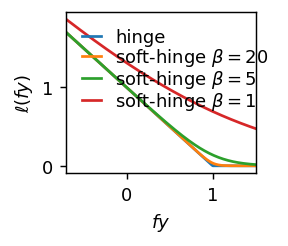

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(2.3, 2), dpi=130)


plt.sca(ax1)
x = torch.linspace(-0.7, 1.5, 200)
plt.plot(x, x.neg().add(1).relu(), label='hinge')
plt.plot(x, torch.nn.functional.softplus(x.neg().add(1), beta=20), label=r'soft-hinge $\beta=20$')
plt.plot(x, torch.nn.functional.softplus(x.neg().add(1), beta=5), label=r'soft-hinge $\beta=5$')
plt.plot(x, torch.nn.functional.softplus(x.neg().add(1), beta=1), label=r'soft-hinge $\beta=1$')

plt.legend(handlelength=1, labelspacing=0, frameon=False)
plt.xlabel(r'$fy$')
plt.ylabel(r'$\ell(fy)$')
plt.xlim(min(x), max(x))

plt.tight_layout()
plt.savefig('loss.pdf')

# Disentangling feature learning versus lazy learning from performance

In [ ]:
load("F10k3Lsp_alpha")
load("F10k3Lsp_adam")

[]

NotADirectoryError: F10k3Lsp_h_init does not exists

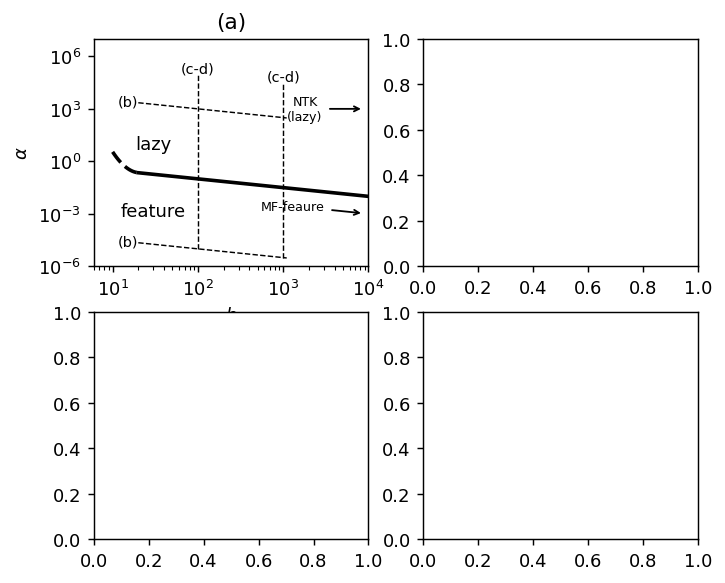

In [ ]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(6, 5), dpi=130)



plt.sca(ax1)
x1, x2 = 20, 10000
y1, y2 = 20 ** -0.5, 10000 ** -0.5
plt.plot([x1, x2], [y1, y2], 'k', linewidth=2)
x = torch.linspace(10, 20, 20)
plt.plot(x, torch.exp(5*(x.log() - math.log(x1)) ** 2 + (math.log(y2)-math.log(y1))/(math.log(x2)-math.log(x1)) * (x.log()-math.log(x1)) + math.log(y1)), 'k--', linewidth=2)

plt.xscale('log')
plt.yscale('log')

plt.xlim(6, 10000)
plt.ylim(1e-6, 1e7)

plt.annotate(r"feature", (3e1, 1.5e-3), horizontalalignment='center', verticalalignment='center')
plt.annotate(r"lazy", (3e1, 1e1), horizontalalignment='center', verticalalignment='center')

plt.annotate("NTK\n(lazy)", xy=(9e3, 1e3), xytext=(1.8e3, 1e3), fontsize=7, arrowprops=dict(arrowstyle="->"), horizontalalignment='center', verticalalignment='center')
# plt.annotate("MF-lazy", xy=(9e3, 10 * 9e3 ** -0.5), xytext=(15e2, 10 * 15e2 ** -0.5), fontsize=7, arrowprops=dict(arrowstyle="->"), horizontalalignment='center', verticalalignment='center')
plt.annotate("MF-feaure", xy=(9e3, 0.1 * 9e3 ** -0.5), xytext=(13e2, 0.1 * 13e2 ** -0.5), fontsize=7, arrowprops=dict(arrowstyle="->"), horizontalalignment='center', verticalalignment='center')

plt.plot([20, 1100], [1e-4 * 20 ** -0.5, 1e-4 * 1100 ** -0.5], '--k', linewidth=0.8)
plt.plot([20, 1100], [1e4 * 20 ** -0.5, 1e4 * 1100 ** -0.5], '--k', linewidth=0.8)
plt.plot([100, 100], [1e-4 * 100 ** -0.5, 1e6 * 100 ** -0.5], '--k', linewidth=0.8)
plt.plot([1000, 1000], [1e-4 * 1000 ** -0.5, 1e6 * 1000 ** -0.5], '--k', linewidth=0.8)
plt.annotate(r"(b)", (1.5e1, 2.5e3), fontsize=8, horizontalalignment='center', verticalalignment='center')
plt.annotate(r"(b)", (1.5e1, 2.5e-5), fontsize=8, horizontalalignment='center', verticalalignment='center')
plt.annotate(r"(c-d)", (1e2, 2e5), fontsize=8, horizontalalignment='center', verticalalignment='center')
plt.annotate(r"(c-d)", (1e3, 7e4), fontsize=8, horizontalalignment='center', verticalalignment='center')

plt.xlabel(r'$h$')
plt.ylabel(r'$\alpha$')
plt.title('(a)')



plt.sca(ax2)
runs = load("F10k3Lsp_h_init")
runs = [r for r in runs if 'init_kernel' in r]
runs = [r for r in runs if r['args'].tau_over_h == 0]
runs = [r for r in runs if nd(r['init_kernel']['train'], r['args'].alpha) == 0]

hs = sorted({r['args'].h for r in runs})
vs = [mean(err(r['init_kernel']['test']) for r in runs if r['args'].h == h) for h in hs]
plt.plot(hs, vs, label=r'init. ker.', color='k')

runs = load("F10k3Lsp_h", predicate=lambda args: args.alpha in [1e-4, 1e-2, 1e0, 1e4])
runs = [r for r in runs if 'regular' in r]
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]

for a in sorted({r['args'].alpha for r in runs}, reverse=True):
    rs = [r for r in runs if r['args'].alpha == a]

    hs = sorted({r['args'].h for r in rs})
    vs = [mean(err(r['regular']['test']) for r in rs if r['args'].h == h) for h in hs]
    plt.plot(hs, vs, label=r'$\sqrt{{h}} \alpha = {}$'.format(texnum(a)))


plt.yticks([0, 0.01, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045], ['0', '1%', '2%', '2.5%', '3%', '3.5%', '4%', '4.5%'])
plt.xscale('log')
plt.legend(labelspacing=0, frameon=False)
plt.xlabel('$h$')
plt.ylabel('test error')
plt.ylim(0.025, 0.05)
plt.xlim(10, 1390)
plt.title('(b)')



plt.sca(ax3)
runs = load("F10k3Lsp_alpha")
runs = [r for r in runs if r['args'].tau_over_h == 0]
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]
hs = sorted({r['args'].h for r in runs})

for h in hs:
    rs = [r for r in runs if r['args'].h == h]
    als = sorted({r['args'].alpha for r in rs})

    xs = [a / h**0.5 for a in als]
    vs = [mean(err(r['regular']['test']) for r in rs if r['args'].alpha == a) for a in als]
    plt.plot(xs, vs, label=r'$h = {}$'.format(h))

plt.xscale('log')
plt.legend(labelspacing=0, frameon=False)
plt.xlabel(r'$\alpha$')
plt.ylabel('test error')
plt.yticks([0, 0.01, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045], ['0', '1%', '2%', '2.5%', '3%', '3.5%', '4%', '4.5%'])
plt.xlim(4e-6, 1e6)
plt.ylim(0.025, 0.035)
plt.title('(c)')



plt.sca(ax4)
runs = load("F10k3Lsp_alpha")
runs = [r for r in runs if r['args'].tau_over_h == 0]
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]
hs = sorted({r['args'].h for r in runs})

for h in hs:
    rs = [r for r in runs if r['args'].h == h]
    als = sorted({r['args'].alpha for r in rs})
    als = [a for a in als if a > 1e-1]

    vs = [mean(err(r['regular']['test']) for r in rs if r['args'].alpha == a) for a in als]
    m1 = min(vs)
    m2 = max(vs)
    vs = [(x - m1) / (m2 - m1) for x in vs]
    plt.plot(als, vs, label=r'$h = {}$'.format(h))

plt.xscale('log')
plt.legend(labelspacing=0, frameon=False)
plt.xlabel(r'$\sqrt{h} \alpha$')
plt.ylabel('rescaled test error')
plt.xlim(min(als), max(als))
plt.title('(d)')






plt.tight_layout()
plt.savefig('test_error.pgf')